In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

/home/tomi/miniconda3/envs/nnenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting to GPU if available
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using: {device}")

Using: cuda


In [3]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder("../data/Training", transform=transform)
test_dataset = datasets.ImageFolder("../data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [4]:
# Flexible CNN architecture to allow variable number of blocks
class FlexibleCNN(nn.Module):
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout, fc_size):
        super(FlexibleCNN, self).__init__()

        blocks = []

        in_channels = 3

        for i in range(n_layers):

            # Get the parameters for the current convolutional layer
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]
            # Calculate padding to maintain the input spatial dimensions ('same' padding)
            padding = (kernel_size - 1) // 2

            # Individual CNN block
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            
            # Add the newly created block to the list
            blocks.append(block)

            # Update the number of input channels for the next block
            in_channels = out_channels

        # Combine all blocks into a single feature extractor module
        self.features = nn.Sequential(*blocks)

        # Store hyperparameters needed for building the classifier later
        self.dropout = dropout
        self.fc_size = fc_size

        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.fc_size, 4)
        ).to(device)

    def forward(self, x):
        device = x.device

        x = self.features(x)

        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        return self.classifier(flattened)

In [5]:
# Train and eval functions

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Tracking progress
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    # Calculate the average accuracy for the epoch
    epoch_acc = correct / total

    # Return the epoch's average loss and accuracy
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(images)
            
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total

    return accuracy

In [6]:
# Optuna Objective Function
def obj(trial, device):
    # Hyperparameter search space
    
    n_layers = trial.suggest_int("n_layers", 1, 4)
    n_filters = [trial.suggest_int(f"n_filters_{i}", 16, 256, step=16) for i in range(n_layers)]
    kernel_sizes = [trial.suggest_categorical(f"kernel_size_{i}", [3, 5]) for i in range(n_layers)]

    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    fc_size = trial.suggest_int("fc_size", 64, 512, step=16)
    
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # Instantiate the model using given parameters
    model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout, fc_size).to(device)

    # Fixed parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    EPOCHS = 10
    
    # Train and evaluate
    for epoch in range(EPOCHS):
        train_epoch(model, train_loader, criterion, optimizer, device)
    
    accuracy = evaluate(model, test_loader, device)

    # Clean up to avoid memory buildup
    del model, optimizer, criterion
    torch.cuda.empty_cache()

    return accuracy

In [7]:
# Optuna study
# Maximise the returned value of the evaluation accuracy
study = optuna.create_study(direction='maximize')

n_trials = 50
study.optimize(lambda trial: obj(trial, device), n_trials=n_trials)

[I 2025-11-30 15:21:41,019] A new study created in memory with name: no-name-595e419a-89ed-4d29-a5cc-fbea83441e0b
[I 2025-11-30 15:23:17,000] Trial 0 finished with value: 0.48984771573604063 and parameters: {'n_layers': 4, 'n_filters_0': 256, 'n_filters_1': 80, 'n_filters_2': 160, 'n_filters_3': 144, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 3, 'kernel_size_3': 3, 'dropout': 0.3998998403995466, 'fc_size': 64, 'lr': 0.004730947693202546}. Best is trial 0 with value: 0.48984771573604063.
[I 2025-11-30 15:23:46,196] Trial 1 finished with value: 0.350253807106599 and parameters: {'n_layers': 1, 'n_filters_0': 64, 'kernel_size_0': 3, 'dropout': 0.2836058707626147, 'fc_size': 240, 'lr': 0.00029479883360995215}. Best is trial 0 with value: 0.48984771573604063.
[I 2025-11-30 15:24:56,993] Trial 2 finished with value: 0.6243654822335025 and parameters: {'n_layers': 4, 'n_filters_0': 160, 'n_filters_1': 112, 'n_filters_2': 64, 'n_filters_3': 256, 'kernel_size_0': 3, 'kernel_size_1

In [8]:
df = study.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_fc_size,params_kernel_size_0,params_kernel_size_1,params_kernel_size_2,params_kernel_size_3,params_lr,params_n_filters_0,params_n_filters_1,params_n_filters_2,params_n_filters_3,params_n_layers,state
0,0,0.489848,2025-11-30 15:21:41.020621,2025-11-30 15:23:16.999810,0 days 00:01:35.979189,0.399900,64,3,3.0,3.0,3.0,0.004731,256,80.0,160.0,144.0,4,COMPLETE
1,1,0.350254,2025-11-30 15:23:17.001485,2025-11-30 15:23:46.196087,0 days 00:00:29.194602,0.283606,240,3,NaN,NaN,NaN,0.000295,64,NaN,NaN,NaN,1,COMPLETE
2,2,0.624365,2025-11-30 15:23:46.196731,2025-11-30 15:24:56.993443,0 days 00:01:10.796712,0.207617,96,3,3.0,5.0,3.0,0.000425,160,112.0,64.0,256.0,4,COMPLETE
3,3,0.685279,2025-11-30 15:24:56.994074,2025-11-30 15:26:15.692241,0 days 00:01:18.698167,0.218381,240,3,5.0,3.0,5.0,0.000852,192,48.0,160.0,64.0,4,COMPLETE
4,4,0.497462,2025-11-30 15:26:15.692871,2025-11-30 15:27:06.347468,0 days 00:00:50.654597,0.356019,416,3,5.0,5.0,3.0,0.000958,80,80.0,48.0,224.0,4,COMPLETE
5,5,0.373096,2025-11-30 15:27:06.348159,2025-11-30 15:31:25.434280,0 days 00:04:19.086121,0.214632,208,3,NaN,NaN,NaN,0.000313,256,NaN,NaN,NaN,1,COMPLETE
6,6,0.319797,2025-11-30 15:31:25.434955,2025-11-30 15:32:47.023807,0 days 00:01:21.588852,0.117508,144,3,NaN,NaN,NaN,0.002231,224,NaN,NaN,NaN,1,COMPLETE
7,7,0.692893,2025-11-30 15:32:47.024433,2025-11-30 15:34:11.482997,0 days 00:01:24.458564,0.298245,256,5,3.0,5.0,5.0,0.000974,192,96.0,144.0,160.0,4,COMPLETE
8,8,0.403553,2025-11-30 15:34:11.483822,2025-11-30 15:34:31.346837,0 days 00:00:19.863015,0.152188,192,5,3.0,3.0,NaN,0.006654,32,96.0,16.0,NaN,3,COMPLETE
9,9,0.357868,2025-11-30 15:34:31.347491,2025-11-30 15:35:48.697229,0 days 00:01:17.349738,0.200730,80,3,NaN,NaN,NaN,0.005501,240,NaN,NaN,NaN,1,COMPLETE


In [9]:
best_trial = study.best_trial

print("Best trial:")
print(f"  Validation Accuracy: {best_trial.value:.4f}")

print("  Hyperparameters:")
print(best_trial.params)

Best trial:
  Value (Accuracy): 0.7335
  Hyperparameters:
{'n_layers': 4, 'n_filters_0': 256, 'n_filters_1': 80, 'n_filters_2': 48, 'n_filters_3': 240, 'kernel_size_0': 3, 'kernel_size_1': 5, 'kernel_size_2': 3, 'kernel_size_3': 5, 'dropout': 0.1265531928742637, 'fc_size': 400, 'lr': 0.0008484833582874335}


/tmp/ipykernel_680/1137342817.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


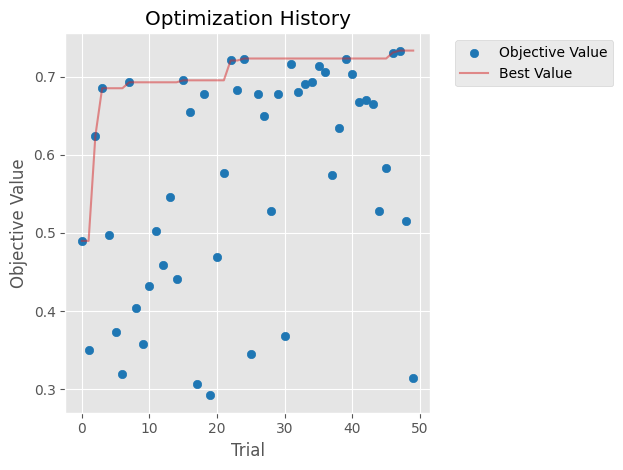

/tmp/ipykernel_680/1137342817.py:7: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


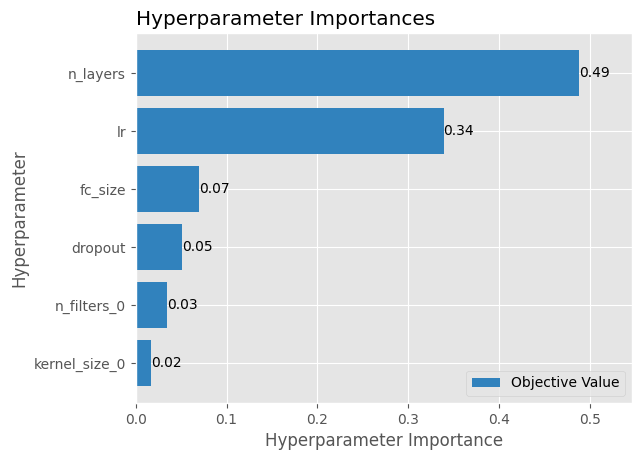

/tmp/ipykernel_680/1137342817.py:10: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_parallel_coordinate(


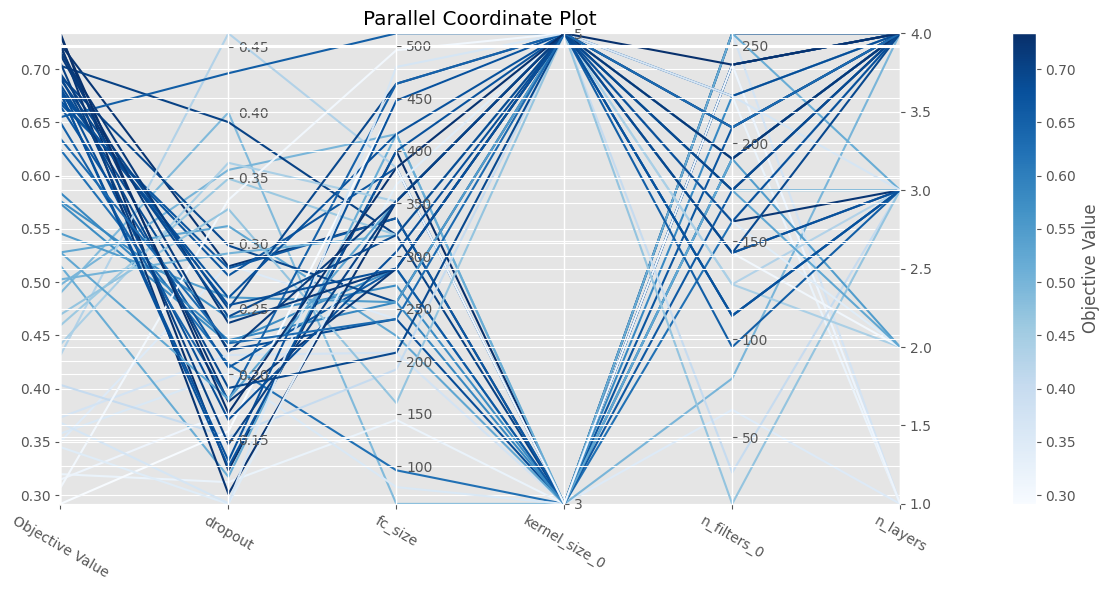

In [13]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

# Importance of hyperparameters
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

ax = optuna.visualization.matplotlib.plot_parallel_coordinate(
    study, params=['n_layers', 'n_filters_0', 'kernel_size_0', 'dropout', 'fc_size']
)
fig = ax.figure
fig.set_size_inches(12, 6, forward=True)  # forward=True updates the canvas
fig.tight_layout();

In [14]:
# Export optuna study and best hyperparameters
#df.to_csv("optuna_study") -- don't overwrite

In [17]:
import json

#with open("best_params.json", "w") as f:
    #json.dump(best_trial.params, f, indent=4) -- don't overwrite